In [1]:
from sklearn.datasets import load_wine
data = load_wine()
X = data.data
y = data.target
class_names = data.target_names
feature_names = data.feature_names
print("Liczba parametrów:", len(feature_names))
print("Liczba klas:", len(class_names))

Liczba parametrów: 13
Liczba klas: 3


In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
print("Liczność zbioru uczącego:", len(X_train))
print("Liczność zbioru testowego:", len(X_test))

Liczność zbioru uczącego: 133
Liczność zbioru testowego: 45


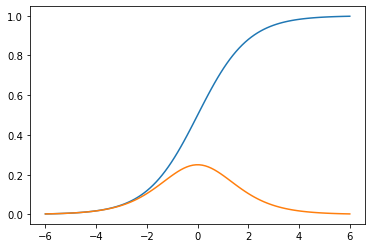

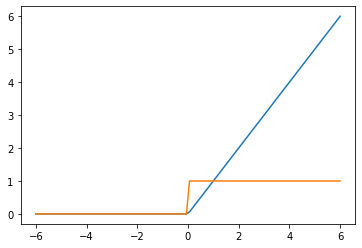

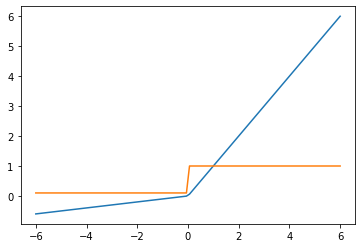

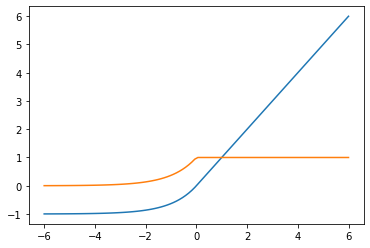

In [3]:
from mlp import sigmoid, relu, leakyrelu, d_sigmoid_dt, d_relu_dt, d_leakyrelu_dt, elu, d_elu_dt
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(-6, 6, 100)
y = np.linspace(-6, 6, 100)
for i in range(len(x)):
    y[i] = sigmoid(x[i])
plt.plot(x, y)
for i in range(len(x)):
    y[i] = d_sigmoid_dt(x[i])
plt.plot(x, y)
plt.show()

for i in range(len(x)):
    y[i] = relu(x[i])
plt.plot(x, y)
for i in range(len(x)):
    y[i] = d_relu_dt(x[i])
plt.plot(x, y)
plt.show()

for i in range(len(x)):
    y[i] = leakyrelu(x[i])
plt.plot(x, y)
for i in range(len(x)):
    y[i] = d_leakyrelu_dt(x[i])
plt.plot(x, y)
plt.show()

for i in range(len(x)):
    y[i] = elu(x[i])
plt.plot(x, y)
for i in range(len(x)):
    y[i] = d_elu_dt(x[i])
plt.plot(x, y)
plt.show()

In [27]:
from mlp import MLP

X_xor_train = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_xor_train = np.array([[0], [1], [1], [0]])

mlp = MLP(2, 3, 1, 1, relu, d_relu_dt)
mlp.fit(X_xor_train, y_xor_train, 1000, 0.1)
mlp.predict(X_xor_train)

[[2.7755575615628914e-17], [1.0], [5.551115123125783e-17], [1.0]]

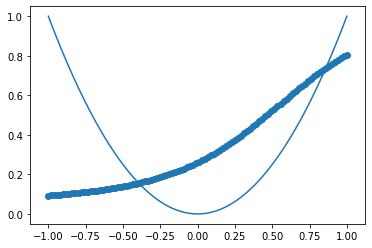

In [44]:
X_square_train = np.linspace(-1, 1, 100)
y_square_train = np.array([x**2 for x in X_square_train])
X_square_train = np.array([[x] for x in X_square_train])
y_square_train = np.array([[y] for y in y_square_train])

X_test = np.linspace(-1, 1, 15)
y_test = np.array([x**2 for x in X_test])
X_test = np.array([[x] for x in X_test])
y_test = np.array([[y] for y in y_test])

mlp = MLP(1, 5, 4, 1, sigmoid, d_sigmoid_dt)
mlp.fit(X_square_train, y_square_train, 100, 0.1)
y_predict = mlp.predict(X_square_train)

plt.plot(X_square_train, y_square_train)
plt.scatter(X_square_train, y_predict)
plt.show()